# NOT:

> BUNU ÖDEVE VERECEĞİM

## Machine Learning
### HS Olmez 2022

## Decision Tree (CART) Model

# Telecom Churn Model using Decision Trees

As we worked on this problem in the fourth lecture on Logistic Regression, we'll skip the introduction of the problem and all the relevant EDA stuff for brevity. Please check the notebook provided in Lecture 4 for details.

## Predictors in the data set
|Feature|Explanation|
|---------|-----------|
|State|Geographic location of the customer|
|Account Length|Length of time customer has been with the company|
|Area Code|Prefix of the phone number|
|Phone|Phone number|
|Int'l Plan|Customer has a plan for International calls?|
|VMail Plan|Customer has a VMail plan?|
|VMail Message|Number of VMail messages|
|Day Mins|Length of day-time calls|
|Day Calls|Number of day-time calls|
|Day Charge|Cost of day-time calls|
|Eve Mins|Length of evening calls|
|Eve Calls|Number of evening calls|
|Eve Charge|Cost of evening calls|
|Night Mins|Length of night-time calls|
|Night Calls|Number of night-time calls|
|Night Charge|Cost of night-time calls|
|Intl Mins|Length of international calls|
|Intl Calls|Number of international calls|
|Intl Charge|Cost of international calls|
|CustServ Calls|Number of calls made to Call Center|
|Churn?|Customer churned or not? (our label)|

In [1]:
import warnings
warnings.filterwarnings("ignore") # Don't want to see the warnings in the notebook

In [2]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from operator import itemgetter
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
%matplotlib inline

In [5]:
#Let's read the data file 
df = pd.read_csv('/home/volkan/Documents/Programming/datasets/Classification/churn.txt', sep=',')
col_names = df.columns.tolist()

## Step 1
A couple of bookkeeping stuff first:<br>
We'll rename 'Churn?' as 'Churn' and remove the (') sign from the attribute (Int'l Plan). We'll then replace the white space in the names of the attributes by the underscore to make them a single word. 

In [6]:
df.rename(columns={'Churn?':'Churn' , 'Int\'l Plan':'Intl_Plan'}, inplace=True) #Rename these two columns
#Replace the white space in column names by an underscore
newcols = df.columns
newcols = newcols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, bytes)) else x) #Use unicode for bytes in Python 2.x
df.columns = newcols

## Step 2
Assuming that features like state, area code and phone number won't have a predictive power on churn, we'll drop them. You may argue that state might play a role on churn but let's pretend that it doesn't. We'll insert the Boolean (True/False) equivalents for the categorical features Intl_Plan, VMail_Plan and Churn.

In [7]:
df.drop(['State','Area_Code','Phone'], inplace=True, axis=1) #Overwrites the data frame
#or using the column numbers: df.drop(df.columns[[0, 1, 3]], axis=1) (1st, 2nd and 4th columns...)

#Replace True. by its Boolean equivalent 'True' (False otherwise):
df['Churn'] = df['Churn'] == 'True.'

# We'll replace the 'yes' and 'no' values for 'Intl Plan' and 'VMail Plan' by their Boolean counterparts:
yes_no_cols = ['Intl_Plan','VMail_Plan']
df[yes_no_cols] = df[yes_no_cols] == 'yes'

Correlation matrix found in Lecture-4 revealed that (VMail_Plan,VMail_Message), (Day_Mins, Day_Charge),(Eve_Mins,Eve_Charge), (Night_Mins,Night_Charge) and (Intl_Mins, Intl_Charge) pairs are perfectly correlated. So we'll drop one of the features in each pair.

In [8]:
df.drop(['Day_Charge','Eve_Charge','Night_Charge', 'Intl_Charge'], inplace=True, axis=1)
col_names = df.columns.tolist()

Out of 3333 instances, number of customers churning is 483, non-churning 2850. We have an unbalanced data set! We have to keep this in mind for the cross-validation phase and for the evaluation of the overall prediction accuracy.<br>

## Step 3 : Decision Trees - Building the model
In this step, we'll fit a Decision Tree model to our data. We need to represent our dataframe as a matrix as expected by  the scikit module now. We convert the pandas dataframe into a numpy matrix (for both X and y) down below:

In [9]:
y = np.array(df['Churn'])
X = np.array(df.drop(['Churn'], axis=1))
print('X and y:', X.shape, y.shape)

X and y: (3333, 13) (3333,)


As expected, there are 3333 instances (data points) and 13 features for each instance...

In [10]:
#Let's see some of the major statistical characteristics of the attributes:
df.describe()

,Account_Length,VMail_Message,Day_Mins,Day_Calls,Eve_Mins,Eve_Calls,Night_Mins,Night_Calls,Intl_Mins,Intl_Calls,CustServ_Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,8.099010,179.775098,100.435644,200.980348,100.114311,200.872037,100.107711,10.237294,4.479448,1.562856
std,39.822106,13.688365,54.467389,20.069084,50.713844,19.922625,50.573847,19.568609,2.791840,2.461214,1.315491
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,143.700000,87.000000,166.600000,87.000000,167.000000,87.000000,8.500000,3.000000,1.000000
50%,101.000000,0.000000,179.400000,101.000000,201.400000,100.000000,201.200000,100.000000,10.300000,4.000000,1.000000
75%,127.000000,20.000000,216.400000,114.000000,235.300000,114.000000,235.300000,113.000000,12.100000,6.000000,2.000000
max,243.000000,51.000000,350.800000,165.000000,363.700000,170.000000,395.000000,175.000000,20.000000,20.000000,9.000000


Table above shows us that CustServ_Calls, Day_Mins, VMail_Plan and Intl_Plan features seem to characterize differences between customers churning and not churning.

In [11]:
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#
seed = 40 #for reproducibility
#--- Training and test portions of data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=seed, stratify=y)
print('Training and Test sizes:',len(X_train),len(X_test) ) #Dimension of the training and test sets

Training and Test sizes: 2333 1000


## Outcome of the default model:

In [12]:
def_clf = DecisionTreeClassifier(random_state=seed)
def_clf.fit(X_train, y_train)
trn_acc = accuracy_score(y_train, def_clf.predict(X_train))
tst_acc = accuracy_score(y_test, def_clf.predict(X_test))

print('CART training accuracy:', trn_acc)
print('CART test accuracy    :', tst_acc)
print('Tree max depth        :', def_clf.tree_.max_depth)

CART training accuracy: 1.0
CART test accuracy    : 0.918
Tree max depth        : 19


Looks like we have an overfit model here. A training accuracy of 100% is possible if you have a very lucky split for the training set (easy data points are somehow put together), or if you have perfectly separable classes (which we know is not the case), or if you have an overfit model.

The most likely reason for overfitting here is the `max_depth` parameter used for the default model. Default setting for `max_depth` is **None** (no limit on depth), meaning that the tree will grow all the way to depth 19 until it gets all pure leaves.  

## Search for a better model via hyperparameter tuning:

### Use a randomized search (RandomizedSearchCV) first

In RandomizedSearchCV, we sample hyperparameter values a certain number of times from a list or from some distribution which is specified in advance. Unlike GridSearchCV where we specify certain values that are combinatorially tried out, here we specify distributions that cover the hyperparameter space we would like to explore. For example, if you have a hyperparameter whose values are centered around a certain value with a normal distribution, we can select random values from that distribution and use them in our grid search. It could also be a uniform distribution if all values are equally likely.

In randomized search, we also use a parameter called **`n_iter`** which controls the computational burden of the procedure. This parameter limits the number of hyperparameters selected for use in the computations. The default value is 10 meaning that 10 random values will be selected from the specified list or distribution.

In [13]:
from scipy.stats import randint
# Create the random grid either bvy specifying a list
random_grid = {"criterion"       : ['entropy', 'gini'],
              "max_depth"        : [5, 6, 7],
              "max_features"     : [3, 4, 5, 6], 
              "min_samples_split": [2, 3, 4, 5],
              "min_samples_leaf" : [1, 2, 3, 4, 5, 10]
              }

# or by drawing a random number using randint
random_grid = {'criterion'        : ['entropy', 'gini'], # The function to measure the quality of a split
               'max_features'     : randint(2, 10),      # Number of features to consider at every split
               'max_depth'        : randint(1, 10),      # Maximum number of levels in tree
               'min_samples_split': randint(1, 10),      # Minimum number of samples required to split a node
               'min_samples_leaf' : randint(1, 10)}      # Minimum number of samples required at each leaf node

For each iteration, the algorithm will choose a difference combination of the features. Now, we'll instantiate the random search and fit it like any Scikit-Learn model:

In [14]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
dt = DecisionTreeClassifier(random_state=seed)

# Random search of parameters, using 3 fold cross validation
kfolds = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# search across different combinations, and use all available cores
np.random.seed(42)
randomGrid = RandomizedSearchCV(estimator = dt,
                                param_distributions = random_grid,
                                cv = kfolds, 
                                n_iter = 20, # Number of sets in which a hyperparameter is sampled 
                                random_state=seed,
                                verbose = 1,
                                n_jobs = -1)

In [15]:
%%time
# Fit the random search model
randomGrid.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
CPU times: user 365 ms, sys: 38.8 ms, total: 403 ms
Wall time: 2.42 s


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeC...ndom_state=40)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'criterion': ['entropy', 'gini'], 'max_depth': <scipy.stats....x7f5b5a966d50>, 'max_features': <scipy.stats....x7f5b5b703230>, 'min_samples_leaf': <scipy.stats....x7f5b5b643230>, ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",20
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscr

In [16]:
# Best hyperparameters found
randomGrid.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 9,
 'min_samples_leaf': 8,
 'min_samples_split': 4}

In [17]:
# All parameters used in the classifier
randomGrid.best_estimator_

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'entropy'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",8
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",4
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",8
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",9
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",40
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

In [18]:
print('Best CV score in all folds:\n', randomGrid.best_score_, '\n')
print('Average CV score and std dev:\n', np.mean(randomGrid.cv_results_['mean_test_score']), ' (+/-) ',
     np.std(randomGrid.cv_results_['mean_test_score'], ddof=1))

Best CV score in all folds:
 0.9327115659733686 

Average CV score and std dev:
 0.8971052052382525  (+/-)  0.023175278222928745


In [19]:
print('Training accuracy:', randomGrid.score(X_train,y_train))
print('Test accuracy    :', randomGrid.score(X_test, y_test))

Training accuracy: 0.9579939991427346
Test accuracy    : 0.95


### Using GridSearchCV
From these results, we should be able to narrow the range of values for each hyperparameter. Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search.

Altogether, there are 5 * 10 * 7 = 350 settings! However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

In [20]:
param_grid = {"criterion"        : ['entropy', 'gini'],
              "max_depth"        : [6, 7, 8, 9],
              "max_features"     : [4, 5, 6, 7, 8, 9, 10],
              "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9],
              "min_samples_leaf" : [1, 2, 3, 4, 5, 10]
              }

kfolds = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
grid_search = GridSearchCV(estimator = DecisionTreeClassifier(random_state=seed),
                           param_grid = param_grid,
                           cv = kfolds,
                           verbose = 1,
                           n_jobs = -1)

In [21]:
%%time
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 2688 candidates, totalling 26880 fits
CPU times: user 4.83 s, sys: 229 ms, total: 5.05 s
Wall time: 17 s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeC...ndom_state=40)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'criterion': ['entropy', 'gini'], 'max_depth': [6, 7, ...], 'max_features': [4, 5, ...], 'min_samples_leaf': [1, 2, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation

In [22]:
# Best hyperparameters found
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 5}

In [23]:
# All parameters used in the classifier
grid_search.best_estimator_

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'entropy'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",9
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",9
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",40
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

In [24]:
print('Best CV score in all folds:\n', grid_search.best_score_, '\n')
print('Average CV score and std dev:\n', np.mean(grid_search.cv_results_['mean_test_score']), ' (+/-) ',
     np.std(grid_search.cv_results_['mean_test_score'], ddof=1))

Best CV score in all folds:
 0.9447012215252558 

Average CV score and std dev:
 0.9173739322243881  (+/-)  0.014670895541641556


In [25]:
print('Training accuracy:', grid_search.score(X_train,y_train))
print('Test accuracy    :', grid_search.score(X_test, y_test))

Training accuracy: 0.9721388769824261
Test accuracy    : 0.945


## Train with the chosen hyperparameters and compute the test accuracy

Wall time for RandomizedSearchCV abd GridSearchCV were 1.74 and 30.9 sec, respectively. We'll use the hyperparameters selected by the RandomizedSearchCV procedure and adopt:
<pre>
 'criterion'        : 'entropy',
 'max_depth'        : 8,
 'max_features'     : 9,
 'min_samples_leaf' : 8,
 'min_samples_split': 4
</pre>

In [26]:
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, max_features = 9,
                            min_samples_split = 4, min_samples_leaf = 8, random_state=seed)
dt.fit(X_train, y_train)
trn_acc = accuracy_score(y_train, dt.predict(X_train))
tst_acc = accuracy_score(y_test, dt.predict(X_test))

print('CART training accuracy:', trn_acc)
print('CART test accuracy    :', tst_acc)

CART training accuracy: 0.9579939991427346
CART test accuracy    : 0.95


## Confusion Matrix

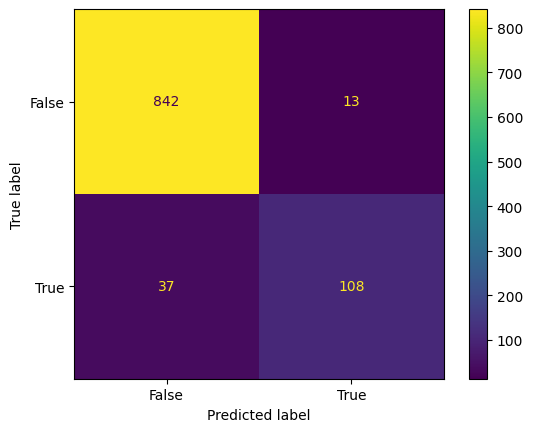

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)
plt.grid(False)

## Feature importance

 Account_Length: 0.02632
      Intl_Plan: 0.08728
     VMail_Plan: 0.01821
  VMail_Message: 0.04791
       Day_Mins: 0.27923
      Day_Calls: 0.02130
       Eve_Mins: 0.14404
      Eve_Calls: 0.00196
     Night_Mins: 0.03810
    Night_Calls: 0.01915
      Intl_Mins: 0.08413
     Intl_Calls: 0.06282
 CustServ_Calls: 0.16954


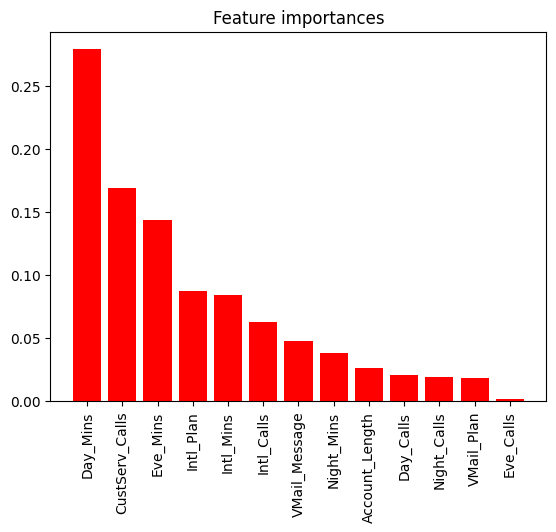

In [31]:
importance = dt.feature_importances_
features = df.columns.tolist()
# summarize feature importance
for i,v in enumerate(importance):
    print('%15s: %.5f' % (features[i],v))

# plot feature importance
indices = np.argsort(importance)[::-1]
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importance[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation='vertical')
plt.show()

## Step 4 : Learning curves for Decision Trees

In [32]:
from sklearn.model_selection import learning_curve
# Put the following in a separate .py file and then use   %load filename.py   for importing it
#Ref: http://scikit-learn.org/stable/modules/learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(0.01, 1.0, 50)):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, '-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, '-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid("on")
    return plt

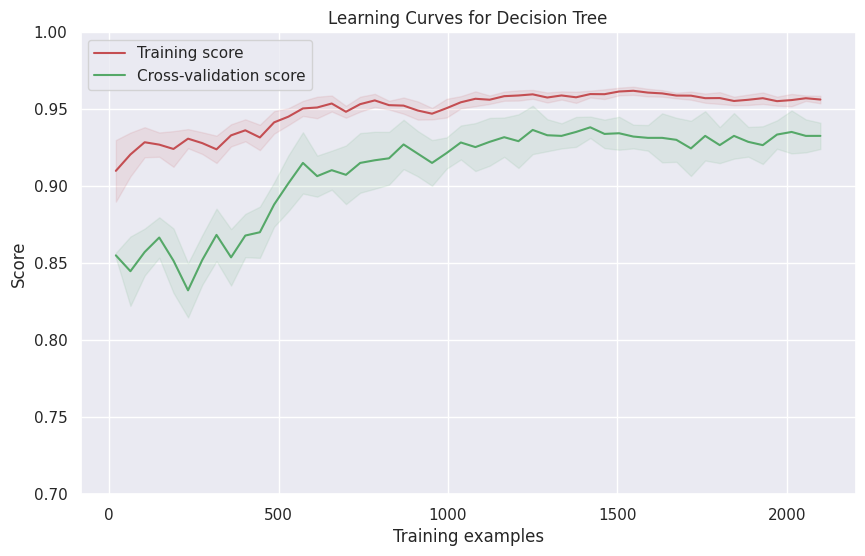

In [33]:
sns.set()
kfold = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
title = 'Learning Curves for Decision Tree'
estimator = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, max_features = 9,
                            min_samples_split = 4, min_samples_leaf = 8, random_state=seed)
plot_learning_curve(estimator, title, X_train, y_train, cv=kfold)
plt.ylim(0.7, 1.0)
plt.show()

## Step 5 : Visualization for the Decision Tree model

## Here is how we can visualize the tree:

#### For Windows:
* `conda install graphviz`
* `conda install python-graphviz`
* `conda install pydot`
* `conda install -c conda-forge pydotplus`

#### For Mac OSx (Catalina)
* `conda install graphviz`
* `conda install python-graphviz`
* `conda install pydot`
* `conda install pydotplus`

For colors and other setting in the tree, see:<br>
https://stackoverflow.com/questions/42891148/changing-colors-for-decision-tree-plot-created-using-export-graphviz<br>
https://stackoverflow.com/questions/43214350/color-of-the-node-of-tree-with-graphviz-using-class-names

To create a .png file out of a .dot file from within the notebook:<br>
<pre>
!dot -Tpng mytree.dot > mytree.png
</pre>

In [34]:
attributes_in_use = ['Account_Length', 'Intl_Plan', 'VMail_Plan', 'VMail_Message',
                     'Day_Mins', 'Day_Calls', 'Eve_Mins', 'Eve_Calls', 'Night_Mins',
                     'Night_Calls', 'Intl_Mins', 'Intl_Calls', 'CustServ_Calls']

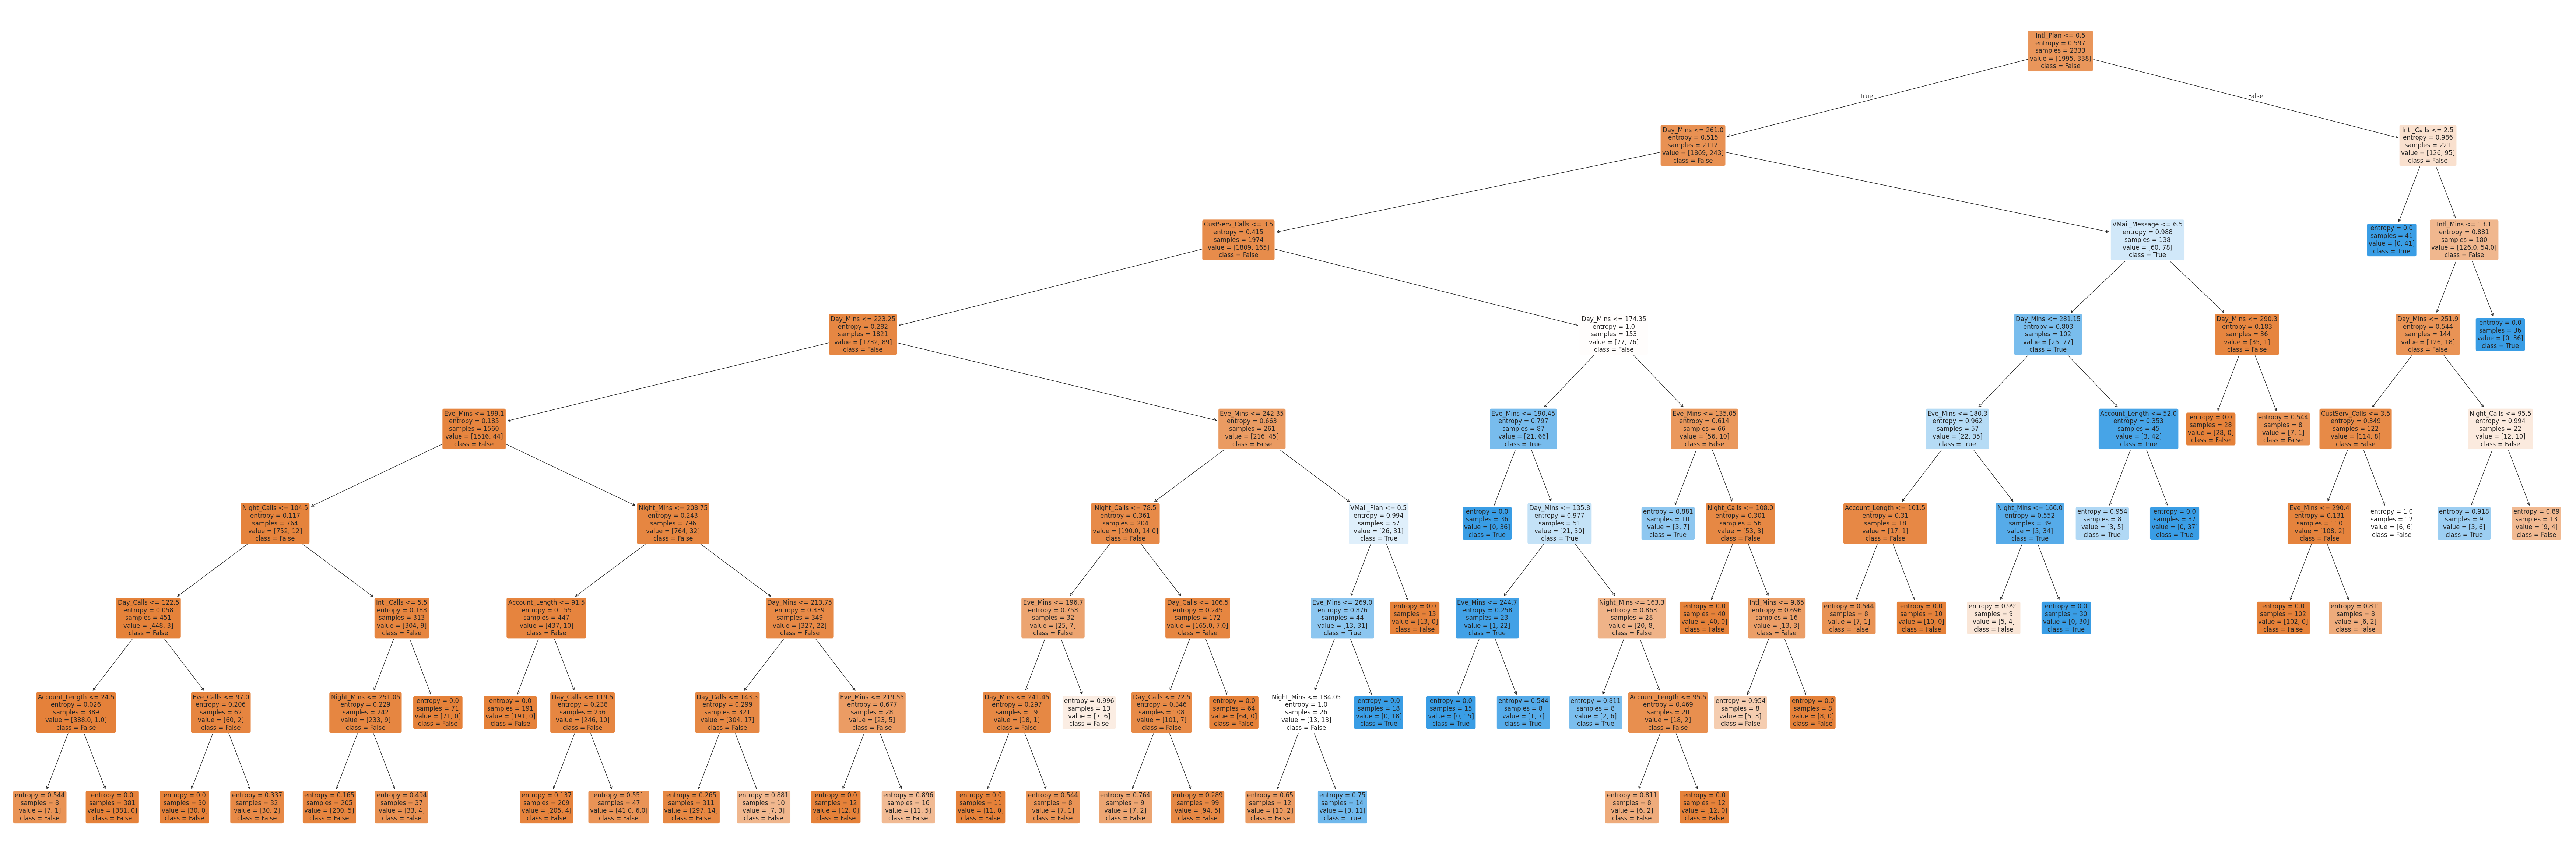

In [35]:
from sklearn import tree
fig = plt.figure(figsize=(90,30))
_ = tree.plot_tree(dt, 
                   feature_names=attributes_in_use,  
                   class_names=['False','True'],
                   rounded=True,
                   filled=True,
                   fontsize=12)

the following trees are produced using the model fitted by GrieSearchCV:

In [36]:
# Order of classes for Churn
dt.classes_

array([False,  True])

In [37]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dt,
                filled=True,
                rounded=True,
                feature_names=df.drop('Churn', axis=1).columns,
                class_names=['Stay', 'Churn'],
                out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

ModuleNotFoundError: No module named 'sklearn.externals.six'

#### Create a png file:

In [ ]:
attributes_in_use = ['Account_Length', 'Intl_Plan', 'VMail_Plan', 'VMail_Message',
                     'Day_Mins', 'Day_Calls', 'Eve_Mins', 'Eve_Calls', 'Night_Mins',
                     'Night_Calls', 'Intl_Mins', 'Intl_Calls', 'CustServ_Calls']

In [ ]:
export_graphviz(dt, out_file="churntree.dot", filled=True, rounded=True, special_characters=True,
                class_names=True, label='all', feature_names = attributes_in_use)
!dot -Tpng churntree.dot > churntree.png